In [1]:
import glob
import sys
import os
import cv2
import numpy as np
print(cv2.__version__)
%matplotlib inline
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
import time

3.4.1


C:\Users\NafiS\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from data_utils import load_tl_extracts
from random_mini_batch import random_mini_batches

setting demintion of each image to 64 * 64

In [3]:
desired_dim = (64,64)
data_dirs = ['data']
test_data = ['test']

## Importing Data

In [4]:
x_train, y_train = load_tl_extracts(data_dirs, desired_dim)
x_test,y_test = load_tl_extracts(test_data, desired_dim)
print('x train shape: ',x_train.shape)
print('y train shape: ',y_train.shape)
print('x test shape: ',x_test.shape)
print('y test shape: ',y_test.shape)

x train shape:  (12503, 64, 64, 3)
y train shape:  (12503,)
x test shape:  (13486, 64, 64, 3)
y test shape:  (13486,)


In [5]:
def show_histogram(y):
    y_set = set(y)
    y_dict = {y: i for i,y in enumerate(y_set)}
    y_n = [y_dict[el] for el in y]
    n_classes = len(y_set)
    
    #distribution of examples per class
    plt.hist(y_n, bins=n_classes);
    plt.xlabel('Class');
    plt.ylabel('Number of samples');
    print(y_dict)

{'yellow': 0, 'off': 1, 'redstraight': 2, 'redstraightleft': 3, 'greenright': 4, 'redright': 5, 'background': 6, 'greenstraightleft': 7, 'greenstraightright': 8, 'greenleft': 9, 'red': 10, 'greenstraight': 11, 'green': 12, 'redleft': 13}


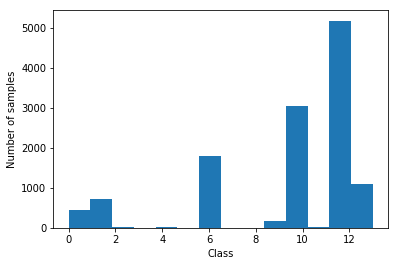

In [6]:
show_histogram(y_train)

In [7]:
#keep only green,red,yellow,off,background
relevant = ['green','off','yellow','red','background']
x_train = x_train[np.isin(y_train, relevant)]
y_train = y_train[np.isin(y_train, relevant)]

{'yellow': 0, 'off': 1, 'background': 2, 'red': 3, 'green': 4}


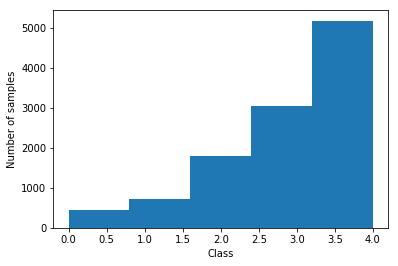

In [8]:
show_histogram(y_train)

In [9]:
def show_images(images, labels_true, rows, cols, cls=None, random=True, labels_predicted=None):
    fig, axes = plt.subplots(rows, cols)
    fig.subplots_adjust(hspace=0.37, wspace=0.3)
    imidx = 0
    for i, ax in enumerate(axes.flat):
        while True:
            if random:
                example = np.random.randint(0, len(images))
            else:
                example = imidx
                imidx += 1
            if cls is None or labels_true[example]==cls:
                break
        if example >= len(images):
            return
        if len(images.shape)==4:
            ax.imshow(images[example,:,:,:]);
        else:
            ax.imshow(images[example,:,:], cmap='Greys_r');
        ax.set_xticks([])
        ax.set_yticks([])
        if labels_predicted is not None:
            str = '{}: true {} pred {}'.format(example, labels_true[example], labels_predicted[example])
        else:
            str = '{}: true {}'.format(example, labels_true[example])
        ax.set_xlabel(str)

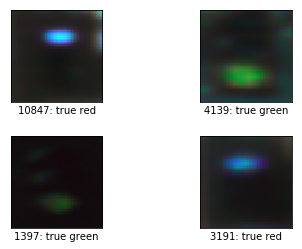

In [10]:
rows = 2
cols = 2
cls = None
show_images(x_train, y_train, rows, cols, cls)

In [11]:
print('After keeping Only 5 Classes: ')
print('x train shape: ',x_train.shape)
print('y train shape: ',y_train.reshape((11189,1)).shape)
print('x test shape: ',x_test.shape)
print('y test shape: ',y_test.reshape((13486,1)).shape)

After keeping Only 5 Classes: 
x train shape:  (11189, 64, 64, 3)
y train shape:  (11189, 1)
x test shape:  (13486, 64, 64, 3)
y test shape:  (13486, 1)


## Splitting the train set into train set and validation set

In [12]:
from sklearn.model_selection import train_test_split
x_train, x_validation, y_train, y_validation = train_test_split(x_train,y_train,test_size=0.33, random_state=42)

#### Covering each image to a column vector

In [13]:
x_train = x_train.reshape(x_train.shape[0], -1).T
x_validation = x_validation.reshape(x_validation.shape[0], -1).T
x_test = x_test.reshape(x_test.shape[0], -1).T
print('x train shape: ',x_train.shape)
print('x validation shape: ',x_validation.shape)
print('x test shape: ',x_test.shape)

x train shape:  (12288, 7496)
x validation shape:  (12288, 3693)
x test shape:  (12288, 13486)


### Normalize image vectors

In [14]:
x_train = x_train/255.
x_validation = x_validation/255.
x_test = x_test/255.

In [15]:
def one_hot_matrix(labels, C):
    """
    Creates a matrix where the i-th row corresponds to the ith class number and the jth column
                     corresponds to the jth training example. So if example j had a label i. Then entry (i,j) 
                     will be 1. 
                     
    Arguments:
    labels -- vector containing the labels 
    C -- number of classes, the depth of the one hot dimension
    
    Returns: 
    one_hot -- one hot matrix
    """
    
    ### START CODE HERE ###
    
    # Create a tf.constant equal to C (depth), name it 'C'. (approx. 1 line)
    C = tf.constant(C, name='C')
    
    # Use tf.one_hot, be careful with the axis (approx. 1 line)
    one_hot_matrix = tf.one_hot(indices=labels, depth=C, axis=0)
    
    # Create the session (approx. 1 line)
    sess = tf.Session()
    
    # Run the session (approx. 1 line)
    one_hot = sess.run(one_hot_matrix)
    
    # Close the session (approx. 1 line). See method 1 above.
    sess.close()
    
    ### END CODE HERE ###
    
    return one_hot

In [16]:
print('True class of first 5 image',y_train[0:5])

True class of first 5 image ['red' 'green' 'off' 'green' 'background']


In [17]:
#setting each class to a integer
data = {}
data['red'] = 0
data['green'] = 1
data['off'] = 2
data['yellow'] = 3
data['background'] = 4

def string_to_int(b):
    y = b
    k = y.shape[0]

    for j in range(0,k):
        if (y[j]=='0' or y[j]=='1' or y[j]=='2' or y[j]=='3' or y[j]=='4'):
            y[j] = y[j]
        else:
            y[j] = data[y[j]]

    y = y.astype(np.int)
    return y


#### one hot matrix convertion

In [18]:
y_train = one_hot_matrix(string_to_int(y_train),C=5)
y_validation = one_hot_matrix(string_to_int(y_validation),C=5)
y_test = one_hot_matrix(string_to_int(y_test),C=5)

print('y train shape: ',y_train.shape)
print('y validation shape: ',y_validation.shape)
print('x test shape: ',y_test.shape)

y train shape:  (5, 7496)
y validation shape:  (5, 3693)
x test shape:  (5, 13486)


In [19]:
print('One hot martrix of first 5 elements:')
print(y_train[:,0:5])
y_tain_true_class = np.array([label.argmax() for label in y_train.T])
y_validation_true_class = np.array([label.argmax() for label in y_validation.T])
y_test_true_class = np.array([label.argmax() for label in y_test.T])
print('True Classes of first 5 elements:')
print(y_tain_true_class[0:5])

One hot martrix of first 5 elements:
[[1. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]]
True Classes of first 5 elements:
[0 1 2 1 4]


In [20]:
print('x train shape: ',x_train.shape)
print('y train shape: ',y_train.shape)
print('x validation shape: ',x_validation.shape)
print('y validation shape: ',y_validation.shape)
print('x test shape: ',x_test.shape)
print('y test shape: ',y_test.shape)

x train shape:  (12288, 7496)
y train shape:  (5, 7496)
x validation shape:  (12288, 3693)
y validation shape:  (5, 3693)
x test shape:  (12288, 13486)
y test shape:  (5, 13486)


### Hyper Parameters Setting

In [21]:
#resetting the default graph of tensorflow
ops.reset_default_graph()

#set size of each batch
minibatch_size = 500

#set random seed for minibatch
seed = 3

#set number of iteration
no_of_epoch = 600

#set layer demintion
layer_dims = [12288,128,64,5]

#total images to train
m = y_train.shape[1]

#learning rate
learning_rate = 0.05

### Initialize Weights & biases

In [22]:
#clreate placeholder for the data input
x = tf.placeholder(tf.float32,shape=[layer_dims[0],None])

y_true = tf.placeholder(tf.float32,[5,None])

y_true_cls = tf.placeholder(tf.int64, [None])

parameters = {}
    
L = len(layer_dims)
    
for l in range(1,L):
    parameters['W'+str(l)] = tf.get_variable('W'+str(l),[layer_dims[l],layer_dims[l-1]],
                                             initializer=tf.contrib.layers.xavier_initializer(seed=1))
    
    parameters['b'+str(l)] = tf.get_variable('b'+str(l),[layer_dims[l],1],initializer=tf.zeros_initializer())
    
    #print(layer_dims[l],layer_dims[l-1])

### forward propagation 

In [23]:
A = x
L = len(parameters)//2

for l in range(1,L):
    A_pre = A
    #print(parameters['W'+str(l)].get_shape(),A_pre.get_shape())
    Z = tf.add(tf.matmul(parameters['W'+str(l)],A_pre),parameters['b'+str(l)])
    A = tf.nn.relu(Z)
    
ZL = tf.add(tf.matmul(parameters['W'+str(L)],A),parameters['b'+str(L)])

y_pred = tf.nn.softmax(ZL, axis=0)
y_pred_cls = tf.argmax(y_pred, axis=0)

### Computing Cost

In [24]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = tf.transpose(ZL), labels = tf.transpose(y_true)))

### Gradient Descent Optimizer

In [25]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(cost)

### Training Function 

In [26]:
session = tf.Session()
session.run(tf.global_variables_initializer())

def optimize(no_of_epoch,seed):
    
    for epoch in range(no_of_epoch):
            
            epoch_cost = 0. 
            
            num_minibatches = int(m / minibatch_size)
            
            seed = seed + 1
            
            minibatches = random_mini_batches(x_train, y_train, minibatch_size, seed)
            
            for minibatch in minibatches:
        
                batch_x , batch_y = minibatch
        
                _ , minibatch_cost = session.run([optimizer, cost], feed_dict={x: batch_x, y_true: batch_y})
            
                epoch_cost += minibatch_cost / num_minibatches
                
            if epoch % 50 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))

### Training

In [27]:
start_time = time.time()
optimize(no_of_epoch,seed=seed)
print("\nTotal Training Time: %s min" % ((time.time() - start_time)/60))

Cost after epoch 0: 1.386454
Cost after epoch 50: 0.241003
Cost after epoch 100: 0.197395
Cost after epoch 150: 0.172779
Cost after epoch 200: 0.151017
Cost after epoch 250: 0.147075
Cost after epoch 300: 0.131723
Cost after epoch 350: 0.115687
Cost after epoch 400: 0.110106
Cost after epoch 450: 0.099296
Cost after epoch 500: 0.140241
Cost after epoch 550: 0.123990

Total Training Time: 22.308359690507253 min


### Predicting Classes

In [28]:
start_time = time.time()
feed_dict={x: x_train, y_true: y_train ,y_true_cls: y_tain_true_class}
y_train_pred = session.run(y_pred_cls,feed_dict)
feed_dict={x: x_validation, y_true: y_validation ,y_true_cls: y_validation_true_class}
y_val_pred = session.run(y_pred_cls,feed_dict)
feed_dict={x: x_test, y_true: y_test ,y_true_cls: y_test_true_class}
y_test_pred = session.run(y_pred_cls,feed_dict)
end_time = time.time()

### Evaluating Result

In [29]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
target_names = ['class 0', 'class 1', 'class 2', 'class 3','class 4']

print("train accuricy: %f" % accuracy_score(y_tain_true_class, y_train_pred))
print("validation accuricy: %f" % accuracy_score(y_validation_true_class, y_val_pred))

train accuricy: 0.960112
validation accuricy: 0.937178


In [30]:
print(classification_report(y_validation_true_class, y_val_pred, target_names=target_names))

             precision    recall  f1-score   support

    class 0       0.94      0.94      0.94      1011
    class 1       0.99      0.96      0.98      1705
    class 2       0.77      0.87      0.81       240
    class 3       0.65      0.62      0.63       139
    class 4       0.92      0.97      0.95       598

avg / total       0.94      0.94      0.94      3693



In [31]:
print("test accuricy: %f" % accuracy_score(y_test_true_class, y_test_pred))

test accuricy: 0.955509


In [32]:
print(classification_report(y_test_true_class, y_test_pred, target_names=target_names))

             precision    recall  f1-score   support

    class 0       0.98      0.98      0.98      5321
    class 1       0.99      0.98      0.98      7569
    class 2       0.56      0.29      0.38       442
    class 3       0.79      0.99      0.88       154
    class 4       0.00      0.00      0.00         0

avg / total       0.97      0.96      0.96     13486



C:\Users\NafiS\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


### Calculating Single image processing time

In [33]:
total_images = y_train.shape[1] + y_validation.shape[1] + y_test.shape[1]
print("Single image prediction time: %s ms" % (((end_time-start_time)/total_images)*1000))

Single image prediction time: 0.4468167661533529 ms


In [49]:
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

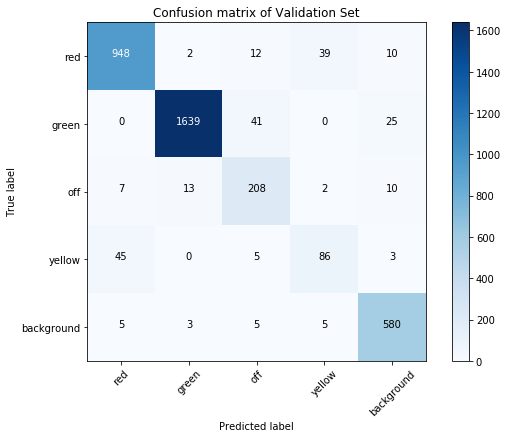

In [52]:
cnf_matrix = confusion_matrix(y_validation_true_class,y_val_pred)
class_names =  ['red','green','off','yellow','background']
plt.figure(figsize = (8,6))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix of Validation Set')

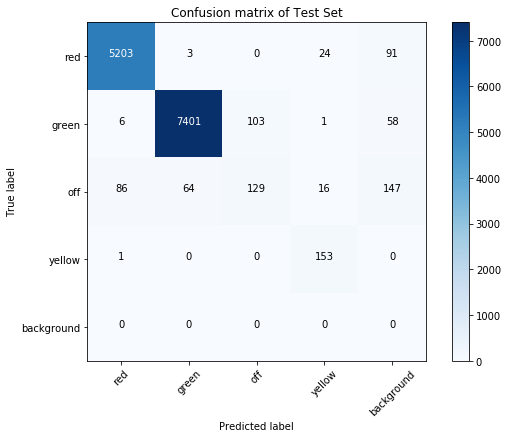

In [53]:
cnf_matrix = confusion_matrix(y_test_true_class,y_test_pred)
plt.figure(figsize = (8,6))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix of Test Set')